In [1]:
import torch
from pykeops.torch import LazyTensor
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src.kernels.rbf import Rbf
from src.kernels.l1_laplace import L1Laplace
from src.experiment_utils import set_precision
from src.data_utils import load_data

In [3]:
CentersDictionary = namedtuple('CentersDictionary',
                               ('idx', 'X', 'probs', 'lam', 'rls_oversample'))

In [4]:
def stable_filter(eigenvec, eigenval):
    """ Given eigendecomposition of a PSD matrix, compute a reduced (thin) version containing only stable eigenvalues.
    """
    n = eigenvec.shape[0]

    if eigenvec.shape != (n, n) or eigenval.shape != (n,):
        raise ValueError(
            f'Array sizes of {eigenvec.shape} eigenvectors and {eigenval.shape} eigenvalues do not match')

    # Threshold formula, similar to numpy/scipy's pinv2 implementation
    thresh = torch.abs(eigenval).max() * max(eigenval.shape) * \
        torch.finfo(eigenval.dtype).eps
    stable_eig = ~torch.isclose(eigenval, torch.tensor(
        0.0, dtype=eigenval.dtype), atol=thresh)

    if torch.any(eigenval <= -thresh):
        raise ValueError(f'Some eigenvalues of a PSD matrix are negative, this should never happen. '
                         f'Minimum eig: {torch.min(eigenval).item()}')

    m = stable_eig.sum().item()
    eigenvec_thin = eigenvec[:, stable_eig]
    eigenval_thin = eigenval[stable_eig]

    if eigenvec_thin.shape != (n, m) or eigenval_thin.shape != (m,):
        raise ValueError(
            f'Array sizes of {eigenvec_thin.shape} eigenvectors and {eigenval_thin.shape} eigenvalues do not match')

    return eigenvec_thin, eigenval_thin


def stable_invert_root(eigenvec, eigenval):
    """ Given eigendecomposition of a PSD matrix, compute a representation of the pseudo-inverse square root
    of the matrix using numerically stable operations. In particular, eigenvalues which are near-zero
    and the associated eigenvectors are dropped from the pseudo-inverse.
    """
    eigenvec_thin, eigenval_thin = stable_filter(eigenvec, eigenval)

    eigenval_thin_inv_root = (1 / torch.sqrt(eigenval_thin)) #.reshape(-1, 1)

    return eigenvec_thin, eigenval_thin_inv_root

In [5]:
def estimate_rls_bless(D, X, kernel, kernel_params, kernel_class, lam_new):
    kernel_temp = kernel_class(LazyTensor(X[:, None, :]), LazyTensor(X[None, :, :]), kernel_params)
    diag_norm = kernel_temp.get_diag().to(X.device)

    # (m x n) kernel matrix between samples in dictionary and dataset X
    D_lazy1 = LazyTensor(D.X[:, None, :])
    D_lazy2 = LazyTensor(D.X[None, :, :])
    X_lazy = LazyTensor(X[None, :, :])
    K_DU = kernel._compute_kernel(D_lazy1, X_lazy, kernel_params)

    K_DD = kernel._compute_kernel(D_lazy1, D_lazy2, kernel_params)
    K_DD = K_DD @ torch.eye(D.X.shape[0], device=X.device)

    U_DD, S_DD, _ = torch.linalg.svd(
        K_DD + lam_new * torch.diag(D.probs))
    U_DD, S_root_inv_DD = stable_invert_root(U_DD, S_DD)

    E = S_root_inv_DD.unsqueeze(1) * U_DD.T

    # compute (X'X + lam*S^(-2))^(-1/2)XX'
    # X_precond = E @ K_DU
    X_precond = (K_DU.T @ E.T).T

    # the diagonal entries of XX'(X'X + lam*S^(-2))^(-1)XX' are just the squared
    # ell-2 norm of the columns of (X'X + lam*S^(-2))^(-1/2)XX'
    rls_estimate = (diag_norm - X_precond.pow(2).sum(dim=0)) / lam_new

    if torch.any(rls_estimate < 0.0):
        raise ValueError(
            'Some estimated RLS is negative, this should never happen. '
            f'Min prob: {torch.min(rls_estimate).item()}'
        )

    return rls_estimate

In [6]:
def reduce_lambda(X_data,
                  kernel,
                  kernel_params,
                  kernel_class,
                  intermediate_dict_bless,
                  lam_new,
                  rls_oversample_parameter=None):
    n, _ = X_data.shape

    if rls_oversample_parameter is None:
        rls_oversample_parameter = intermediate_dict_bless.rls_oversample

    red_ratio = intermediate_dict_bless.lam / lam_new

    if red_ratio < 1.0:
        raise ValueError(f"red_ratio = {red_ratio} is less than 1.0")

    diag = kernel.get_diag().to(X_data.device)

    # compute upper confidence bound on RLS of each sample, overestimate (oversample) by a rls_oversample factor
    # to boost success probability at the expenses of a larger sample (dictionary)
    ucb = torch.minimum(rls_oversample_parameter * diag / (diag + lam_new), torch.tensor(1.0))


    U = torch.rand(n, device=X_data.device) <= ucb
    u = U.sum()

    if u <= 0:
        raise ValueError('No point selected during uniform sampling step, try to increase rls_oversample_bless. '
                         'Expected number of points: {:.3f}'.format(n * ucb.mean()))

    X_U = X_data[U, :]

    rls_estimate = estimate_rls_bless(
        intermediate_dict_bless, X_U, kernel, kernel_params, kernel_class, lam_new)

    # same as before, oversample by a rls_oversample factor
    probs = torch.minimum(rls_oversample_parameter * rls_estimate, ucb[U])
    probs_reject = probs / ucb[U]

    if torch.any(probs < 0.0):
        raise ValueError(f'Some estimated probability is negative, this should never happen. '
                        f'Min prob: {torch.min(probs)}')

    deff_estimate = probs_reject.sum() / rls_oversample_parameter

    if rls_oversample_parameter * deff_estimate < 1.0:
        raise ValueError('Estimated deff is smaller than 1, you might want to reconsider your kernel. '
                         'deff_estimate: {:.3f}'.format(rls_oversample_parameter * deff_estimate))

    selected = torch.rand(u, device=X_data.device) <= probs_reject
    s = selected.sum()

    if s.item() <= 0:
        raise ValueError(
            f'No point selected during RLS sampling step, try to increase rls_oversample_bless. '
            f'Expected number of points (rls_oversample_bless*deff): {probs_reject.sum().item():.3f}'
        )

    intermediate_dict_bless_new = CentersDictionary(
        idx=U.nonzero()[selected.nonzero()],
        X=X_U[selected, :],
        probs=probs[selected],
        lam=lam_new,
        rls_oversample=rls_oversample_parameter
    )

    return intermediate_dict_bless_new

In [ ]:
# def bless(X_data,
#           kernel,
#           kernel_params,
#           kernel_class,
#           lam_final,
#           rls_oversample_param,
#           nb_iter_bless=None):

#     n, _ = X_data.shape

#     if nb_iter_bless is None:
#         nb_iter_bless = torch.ceil(torch.log(torch.tensor(n))).int().item()

#     diag_norm = kernel.get_diag().to(X_data.device)

#     lam_init = n
#     ucb_init = rls_oversample_param * diag_norm / (diag_norm + lam_init)
#     while ucb_init.sum() <= 10:
#         lam_init /= 1.25
#         ucb_init = rls_oversample_param * diag_norm / (diag_norm + lam_init)

#     selected_init = torch.rand(n, device=X_data.device) <= ucb_init
#     selected_init[0] = True  # force at least one sample to be selected

#     ucb_init[0] = rls_oversample_param * 1.0

#     intermediate_dict_bless = CentersDictionary(
#         idx=selected_init.nonzero(),
#         X=X_data[selected_init, :],
#         probs=torch.ones(selected_init.sum(), device=X_data.device) * ucb_init[selected_init],
#         lam=lam_init,
#         rls_oversample=rls_oversample_param
#     )

#     lam_sequence = torch.exp(torch.linspace(
#                                 torch.log(torch.tensor(lam_final)), 
#                                 torch.log(torch.tensor(lam_init)), 
#                                 nb_iter_bless
#                                 )
#                             ).tolist()

#     # discard lam_init from the list, we already used it to initialize
#     lam_sequence.pop()

#     while len(lam_sequence) > 0:
#         lam_new = lam_sequence.pop()
#         intermediate_dict_bless = reduce_lambda(X_data,
#                                                 kernel,
#                                                 kernel_params,
#                                                 kernel_class,
#                                                 intermediate_dict_bless,
#                                                 lam_new)

#     return intermediate_dict_bless

In [8]:
def bless_size(X_data,
               kernel,
               kernel_params,
               kernel_class,
               size_final,
               rls_oversample_param,
               nb_iter_bless=None):
    n, _ = X_data.shape

    diag_norm = kernel.get_diag().to(X_data.device)

    lam_init = diag_norm.sum() / (size_final - 1.0)
    lam_max = lam_init

    lam_final = 1
    lam_min = lam_final

    if nb_iter_bless is None:
        nb_iter_bless = torch.ceil(torch.log2(torch.tensor(lam_init))).int().item()

    lam_sequence = torch.exp(torch.linspace(torch.log(torch.tensor(
        lam_final)), torch.log(torch.tensor(lam_init)), nb_iter_bless)).tolist()

    ucb_init = rls_oversample_param * diag_norm / (diag_norm + lam_init)

    selected_init = torch.rand(n, device=X_data.device) <= ucb_init
    selected_init[0] = True  # force at least one sample to be selected
    ucb_init[0] = rls_oversample_param * 1.0

    intermediate_dict_bless = CentersDictionary(
        idx=selected_init.nonzero(),
        X=X_data[selected_init, :],
        probs=torch.ones(selected_init.sum(),
                         device=X_data.device) * ucb_init[selected_init],
        lam=lam_init,
        rls_oversample=rls_oversample_param
    )

    # discard lam_init from the list, we already used it to initialize
    lam_new = lam_sequence.pop()
    deff_hat_new = size_final - 1

    while len(lam_sequence) > 0:
        lam_old = lam_new
        deff_hat_old = deff_hat_new

        lam_new = lam_sequence.pop()
        intermediate_dict_bless = reduce_lambda(
            X_data,
            kernel,
            kernel_params,
            kernel_class,
            intermediate_dict_bless,
            lam_new)
        deff_hat_new = (len(intermediate_dict_bless.idx)
                        / intermediate_dict_bless.rls_oversample)

        # check if the dictionary passed the lower threshold, in which case set it to last valid lambda
        if deff_hat_old <= (size_final - 1) / 2 <= deff_hat_new:
                lam_max = lam_old

        if deff_hat_new >= 2 * (size_final + 1):
            lam_min = lam_new
            break
        
    return intermediate_dict_bless, lam_max, lam_min

In [9]:
torch.manual_seed(0)
set_precision("float64")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Synthetic data w/ RBF kernel

In [10]:
n = 10000
d = 5
X = torch.randn(n, d, device=device)
kernel_params = {"sigma": 1.0}
kernel = Rbf(LazyTensor(X[:, None, :]), LazyTensor(X[None, :, :]), kernel_params)
kernel_class = Rbf
lam_final = 1.0
size_final = int(n ** 0.5)
rls_oversample_param = 5.0
max_iter_bless = 5

In [11]:
# dict_reduced = bless(X, kernel, kernel_params, kernel_class,
#                       lam_final, rls_oversample_param, nb_iter_bless=max_iter_bless)
dict_reduced, _, _ = bless_size(X, kernel, kernel_params, kernel_class,
                          size_final, rls_oversample_param)
rls_approx = estimate_rls_bless(dict_reduced, X, kernel, kernel_params, kernel_class, lam_final)

/tmp/ipykernel_4086692/4085678775.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nb_iter_bless = torch.ceil(torch.log2(torch.tensor(lam_init))).int().item()
/tmp/ipykernel_4086692/4085678775.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lam_final)), torch.log(torch.tensor(lam_init)), nb_iter_bless)).tolist()


In [12]:
print(f"Number of selected centers = {dict_reduced.X.shape[0]}")

Number of selected centers = 1445


In [13]:
K_true = kernel.K @ torch.eye(n, device=X.device)
rls_true = torch.linalg.solve(K_true + lam_final * torch.eye(n, device=X.device), K_true).diag()

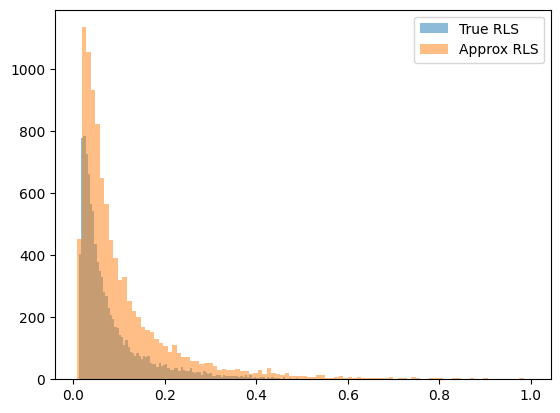

In [14]:
plt.hist(rls_true.cpu().numpy(), bins=100, alpha=0.5, label='True RLS')
plt.hist(rls_approx.cpu().numpy(), bins=100, alpha=0.5, label='Approx RLS')
plt.legend()

### HOMO data w/ L1-laplace kernel

In [15]:
X, _, _, _ = load_data("homo", seed=0, device=device)
n = X.shape[0]
kernel_params = {"sigma": 5120.0}
kernel = L1Laplace(LazyTensor(X[:, None, :]),
             LazyTensor(X[None, :, :]), kernel_params)
kernel_class = L1Laplace
lam_final = 1e-3
size_final = int(n ** 0.5)
rls_oversample_param = 5.0

In [16]:
dict_reduced, _, _ = bless_size(X, kernel, kernel_params, kernel_class,
                                size_final, rls_oversample_param)
rls_approx = estimate_rls_bless(
    dict_reduced, X, kernel, kernel_params, kernel_class, lam_final)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,1574,1) ... 

/tmp/ipykernel_4086692/4085678775.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nb_iter_bless = torch.ceil(torch.log2(torch.tensor(lam_init))).int().item()
/tmp/ipykernel_4086692/4085678775.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lam_final)), torch.log(torch.tensor(lam_init)), nb_iter_bless)).tolist()


OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,1), b=Var(1,435,0), c=Var(2,1,2), d=Var(3,1574,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,148,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,1), b=Var(1,435,0), c=Var(2,1,2), d=Var(3,148,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,209,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(a-b))/c)*d with a=Var(0,435,1), b=Var(1,435,0), c=Var(2,1,2), d=Var(3,209,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum(Abs(

In [17]:
print(f"Number of selected centers = {dict_reduced.X.shape[0]}")

Number of selected centers = 4799


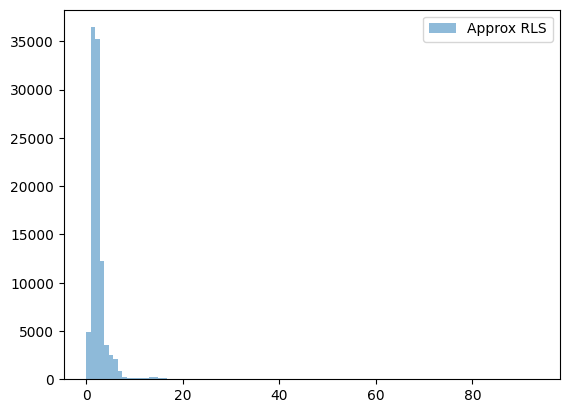

In [18]:
plt.hist(rls_approx.cpu().numpy(), bins=100, alpha=0.5, label='Approx RLS')
plt.legend()

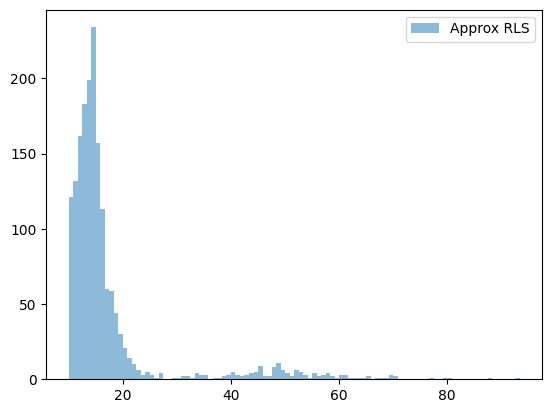

In [19]:
filtered_data = rls_approx[rls_approx > 10].cpu().numpy()
plt.hist(filtered_data, bins=100, alpha=0.5, label='Approx RLS')
plt.legend()

In [20]:
# torch.max(rls_approx)
# torch.min(rls_approx)
# torch.sum(rls_approx)